In [186]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
# %matplotlib notebook
%matplotlib inline
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook


In [377]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

ImportError: cannot import name 'RandomForestClassifier'

Load statuses

In [224]:
path = "/local-scratch/marcthib_scratch/miccai-radiology/datasets_None_4b87ae5a-4ca7-4b95-99f5-09ce31da60e0_README_all_training.txt"
with open(path, "r") as f:
    l = f.readlines()

In [237]:
status = pd.DataFrame(data = {"ytrue": [s.strip("\n").split(" ")[-1] == 'A' for s in l[10:]],
                              "ids": [int(s.strip("\n").split(" ")[0].split("_")[-1]) for s in l[10:]]})
status = status.set_index("ids")

Import radiology features

In [656]:
df_radio = pd.read_csv("data/scores_radiology2.csv")
df_radio = df_radio.loc[:, ["score_radio", "ids", "subids"]]
df_radio

,score_radio,ids,subids
0,0.385915,12,0
1,0.382020,5,0
2,0.390439,24,0
3,0.388805,28,0
4,0.379486,15,0
5,0.383297,21,0
6,0.384353,4,0
7,0.387756,23,0
8,0.376599,3,0
9,0.372487,30,0


In [657]:
df_radio_agg = df_radio.groupby("ids").mean()
df_radio_agg = df_radio_agg.loc[:, ["score_radio"]]
df_radio_agg

,score_radio
ids,
2,0.387510
3,0.375442
4,0.382061
5,0.379677
6,0.396413
7,0.402510
10,0.391747
11,0.387127
12,0.387302


In [621]:
df_radio_agg = pd.read_csv("data/scores_radiology.csv")
df_radio_agg = df_radio_agg.set_index("ids").loc[:, ["score_radiology"]]
df_radio_agg.columns = ['score_radio']
df_radio_agg

,score_radio
ids,
10,0.485326
11,0.485821
12,0.484990
13,0.485930
14,0.486252
15,0.485270
16,0.485758
17,0.486608
19,0.485355


Import pathology features

In [293]:
def preproc_patho(i):
    df = pd.read_csv("../miccai-pathology/pathology_scores_{}.csv".format(i))
    df.columns = ["ids"] + ["score_patho"]
    df["ids"] = [int(x.split("_")[-1]) for x in df.ids]
    df["subids"] = i
    return df

In [294]:
df_patho = pd.concat([preproc_patho(i) for i in range(10)])

In [295]:
df_patho

,ids,score_patho,subids
0,1,0.481027,0
1,10,0.590698,0
2,11,0.497454,0
3,12,0.610640,0
4,13,0.579981,0
5,14,0.517553,0
6,15,0.512107,0
7,16,0.539855,0
8,17,0.637111,0
9,18,0.612150,0


In [301]:
df_patho_agg = df_patho.groupby("ids").mean()
df_patho_agg = df_patho_agg.loc[:, ["score_patho"]]
df_patho_agg

,score_patho
ids,
1,0.481097
2,0.500012
3,0.589389
4,0.567724
5,0.522258
6,0.586472
7,0.488847
8,0.568121
9,0.483140


In [239]:
df_patho = df_patho.join(status)

In [241]:
df_patho.head()

,score_patho,subids,ytrue
ids,,,
1,0.481097,4.5,True
2,0.500012,4.5,True
3,0.589389,4.5,False
4,0.567724,4.5,False
5,0.522258,4.5,False


Combine them

In [841]:
df_combined = df_radio.join(df_patho.set_index(["ids", "subids"]), on=["ids", "subids"]).join(status, on = "ids")
df_combined = df_combined.loc[:, ["score_patho", "score_radio", "ytrue", "subids"]]
df_combined

,score_patho,score_radio,ytrue,subids
0,0.610640,0.385915,False,0
1,0.522056,0.382020,False,0
2,0.652826,0.390439,False,0
3,0.450177,0.388805,True,0
4,0.512107,0.379486,True,0
5,0.502676,0.383297,False,0
6,0.567624,0.384353,False,0
7,0.445429,0.387756,True,0
8,0.589343,0.376599,False,0
9,0.610493,0.372487,False,0


In [659]:
df_combined_agg = df_radio_agg.join(df_patho_agg).join(status)
df_combined_agg = df_combined_agg.loc[:, ["score_patho", "score_radio", "ytrue"]]
df_combined_agg

,score_patho,score_radio,ytrue
ids,,,
2,0.500012,0.387510,True
3,0.589389,0.375442,False
4,0.567724,0.382061,False
5,0.522258,0.379677,False
6,0.586472,0.396413,False
7,0.488847,0.402510,True
10,0.589736,0.391747,False
11,0.497006,0.387127,True
12,0.610795,0.387302,False


**Plot cloud**

All virtual patients

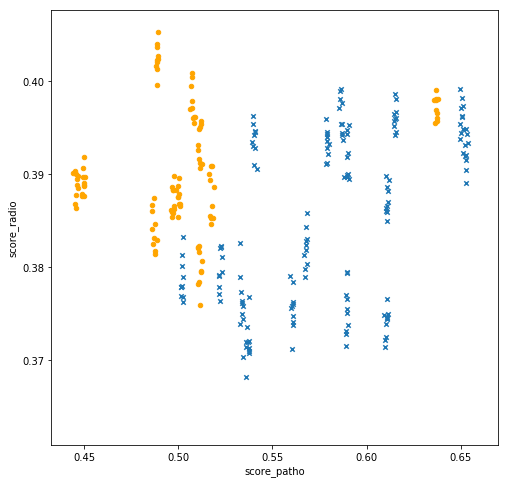

In [842]:
fig, ax = plt.subplots(figsize=(8, 8))
df_combined.query("ytrue==0.").plot.scatter(x="score_patho", y="score_radio", marker="x", ax=ax)
df_combined.query("ytrue==1.").plot.scatter(x="score_patho", y="score_radio", marker="o", ax=ax, c='orange')


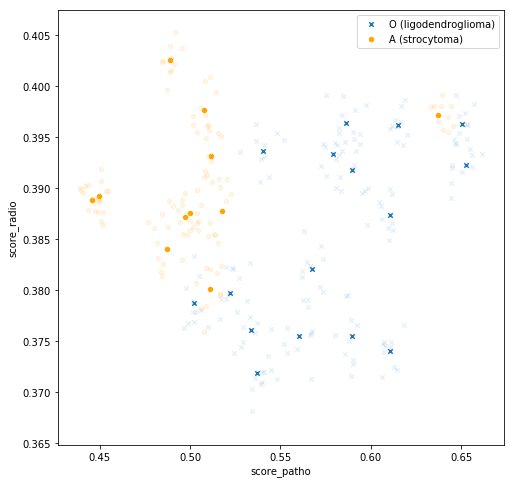

In [847]:
fig, ax = plt.subplots(figsize=(8, 8))
df_combined_agg.query("ytrue==0.").plot.scatter(x="score_patho", y="score_radio", marker="x", ax=ax, label="O (ligodendroglioma)")
df_combined_agg.query("ytrue==1.").plot.scatter(x="score_patho", y="score_radio", marker="o", ax=ax, c='orange', label="A (strocytoma)")

d = df_combined.copy()
d["score_patho"] = df_combined["score_patho"] + 0.005 * np.random.randn(len(df_combined["score_patho"]))
d.query("ytrue==0.").plot.scatter(x="score_patho", y="score_radio", marker="x", ax=ax, alpha=.1)
d.query("ytrue==1.").plot.scatter(x="score_patho", y="score_radio", marker="o", ax=ax, c='orange', alpha=.1)


Single virtual patient

(0.365, 0.405)

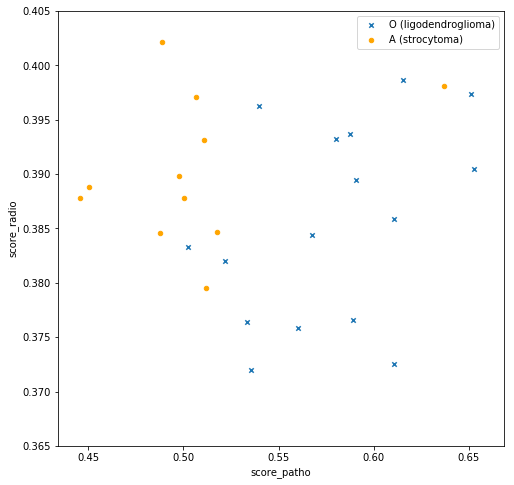

In [805]:
fig, ax = plt.subplots(figsize=(8, 8))
d = df_combined.query("subids == 0")
d.query("ytrue==0.").plot.scatter(x="score_patho", y="score_radio", marker="x", ax=ax, label="O (ligodendroglioma)")
d.query("ytrue==1.").plot.scatter(x="score_patho", y="score_radio", marker="o", ax=ax, c='orange', label="A (strocytoma)")
plt.legend()
plt.ylim([0.365, 0.405])

Average patients

(0.365, 0.405)

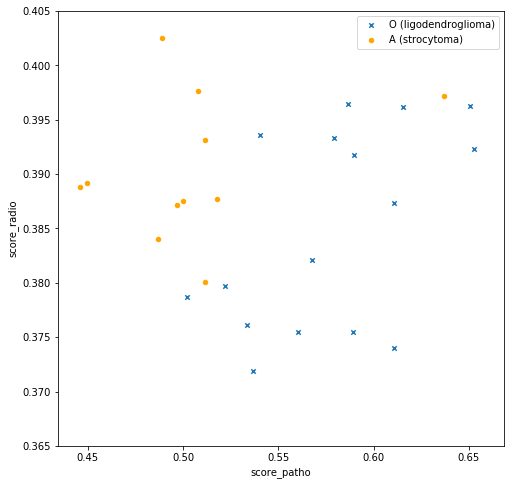

In [712]:
fig, ax = plt.subplots(figsize=(8, 8))
df_combined_agg.query("ytrue==0.").plot.scatter(x="score_patho", y="score_radio", marker="x", ax=ax, label="O (ligodendroglioma)")
df_combined_agg.query("ytrue==1.").plot.scatter(x="score_patho", y="score_radio", marker="o", ax=ax, c='orange', label="A (strocytoma)")
plt.legend()
plt.ylim([0.365, 0.405])

Provide with helper functions

In [140]:
def plot_ROCs(y_score, y_true):
    fig = plt.figure(figsize=(6, 6))
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    print(auc)
    plt.plot(fpr, tpr, lw=2, c='r', alpha=0.8)#, label = r'%s (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.show()


In [199]:
def roc_fts(df):
    X = df.drop("ytrue", axis=1).values
    y = df["ytrue"].values

    r = LogisticRegression(class_weight='balanced') # REGULARIZE BY CROSS-VALIDATION, by optimizing AUC (too many feats, 160, vs samples, 165)
    r.fit(X, y)
    y_score = r.predict_proba(X)[:, 1]

    fig = plt.figure(figsize=(8, 8))
    fpr, tpr, _ = roc_curve(y, y_score)
    auc = roc_auc_score(y, y_score)
    print(auc)
    plt.plot(fpr, tpr, lw=2, c='r', alpha=0.8)#, label = r'%s (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.show()


In-sample feature combination performance

0.8977272727272727


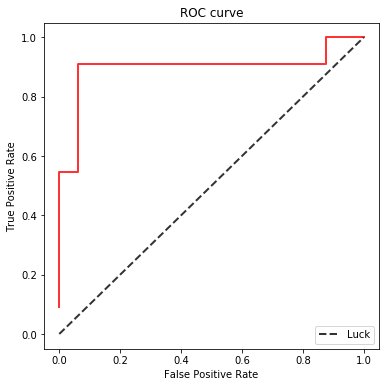

In [147]:
roc_fts(df_combined)

In [218]:
accs = []
d = df_combined.drop("score_radiology", axis=1).sort_values("score_patho")
for th in d.score_patho:
    d["ypred"] = d.score_patho <= th
    accs.append((d["ypred"] == d["ytrue"]).sum())

In [250]:
accs = []
d = df_patho.sort_values("score_patho")
for th in d.score_patho:
    d["ypred"] = d.score_patho <= th
    accs.append((d["ypred"] == d["ytrue"]).sum())

In [636]:
accs = []
d = df_radio_agg.sort_values("score_radio").join(status)
for th in d.score_radio:
    d["ypred"] = d.score_radio >= th
    accs.append((d["ypred"] == d["ytrue"]).mean())

In [638]:
d

,score_radio,ytrue,ypred
ids,,,
21,0.482788,False,False
30,0.482866,False,False
27,0.482981,False,False
22,0.482998,False,False
3,0.483055,False,False
25,0.483352,False,False
5,0.483470,False,False
31,0.484161,True,False
2,0.484253,True,False


In [637]:
max(accs)

0.7037037037037037

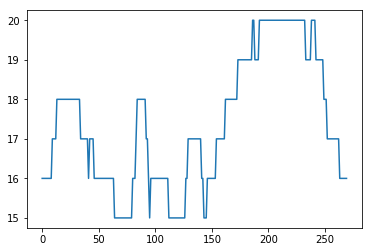

In [628]:
plt.plot(accs)

0.81640625


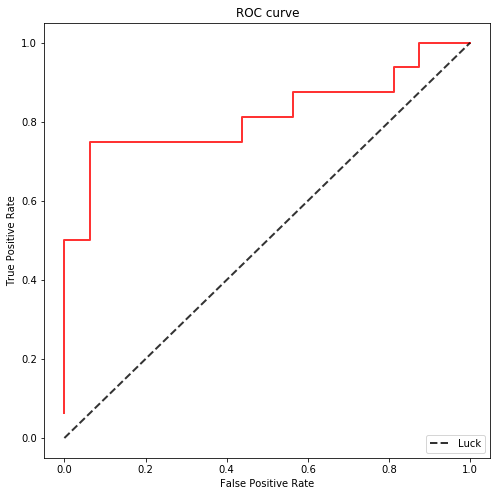

In [252]:
roc_fts(df_patho)

In [745]:
def make_meshgrid(x, y, h=.001, hy = .0001):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, hy))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    # Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

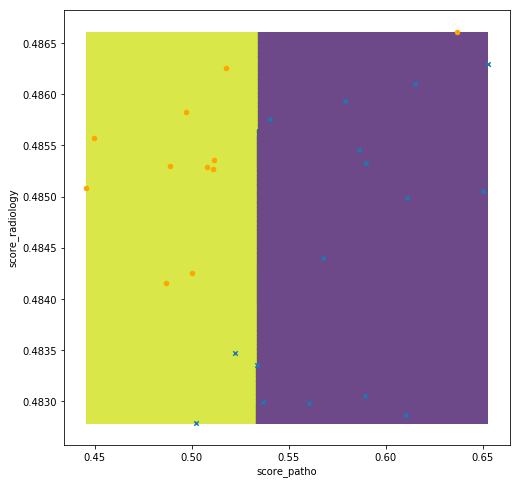

In [185]:
X = df_combined.drop("ytrue", axis=1).values
y = df_combined["ytrue"].values

r = LogisticRegression(class_weight='balanced')
r = LinearSVC(class_weight='balanced')
r = LinearSVC()
r.fit(X, y)
    
fig, ax = plt.subplots(figsize=(8, 8))

xx, yy = make_meshgrid(df_combined.score_patho, df_combined.score_radiology)

plot_contours(ax, r, xx, yy,
                  #cmap=plt.cm.coolwarm, alpha=0.8)
              alpha=0.8)

df_combined.query("ytrue==0.").plot.scatter(x="score_patho", y="score_radiology", marker="x", ax=ax)
df_combined.query("ytrue==1.").plot.scatter(x="score_patho", y="score_radiology", marker="o", ax=ax, c='orange')

In [387]:
from sklearn.linear_model import SGDClassifier

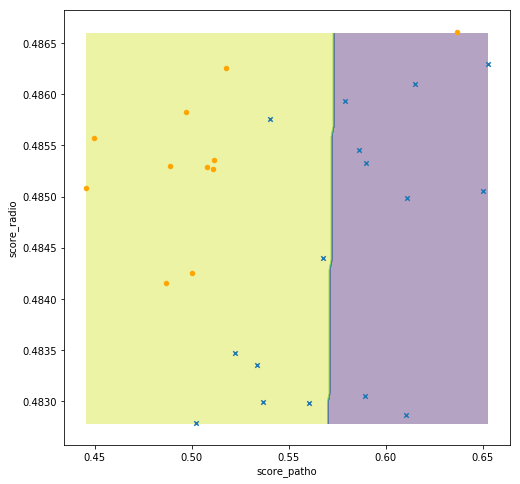

In [532]:
X = df_combined_agg.drop("ytrue", axis=1).values
y = df_combined_agg["ytrue"].values

r = LinearSVC(fit_intercept=True, class_weight="balanced", C=1000, tol = 1e-4)
# r = SGDClassifier(loss='hinge', class_weight="balanced")
r.fit(X, y)

fig, ax = plt.subplots(figsize=(8, 8))

xx, yy = make_meshgrid(df_combined_agg.score_patho, df_combined_agg.score_radio, )

plot_contours(ax, r, xx, yy,
                  #cmap=plt.cm.coolwarm, alpha=0.8)
              alpha=0.4)

df_combined_agg.query("ytrue==0.").plot.scatter(x="score_patho", y="score_radio", marker="x", ax=ax)
df_combined_agg.query("ytrue==1.").plot.scatter(x="score_patho", y="score_radio", marker="o", ax=ax, c='orange')


In [533]:
from sklearn.model_selection import GridSearchCV

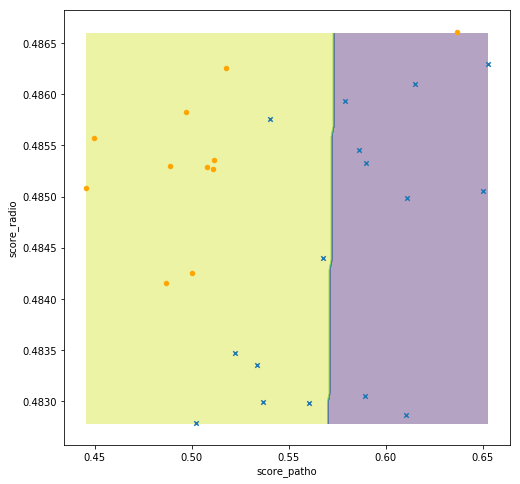

In [532]:
X = df_combined_agg.drop("ytrue", axis=1).values
y = df_combined_agg["ytrue"].values

r = LinearSVC(fit_intercept=True, class_weight="balanced", C=1000, tol = 1e-4)
# r = SGDClassifier(loss='hinge', class_weight="balanced")
r.fit(X, y)

fig, ax = plt.subplots(figsize=(8, 8))

xx, yy = make_meshgrid(df_combined_agg.score_patho, df_combined_agg.score_radio, )

plot_contours(ax, r, xx, yy,
                  #cmap=plt.cm.coolwarm, alpha=0.8)
              alpha=0.4)

df_combined_agg.query("ytrue==0.").plot.scatter(x="score_patho", y="score_radio", marker="x", ax=ax)
df_combined_agg.query("ytrue==1.").plot.scatter(x="score_patho", y="score_radio", marker="o", ax=ax, c='orange')


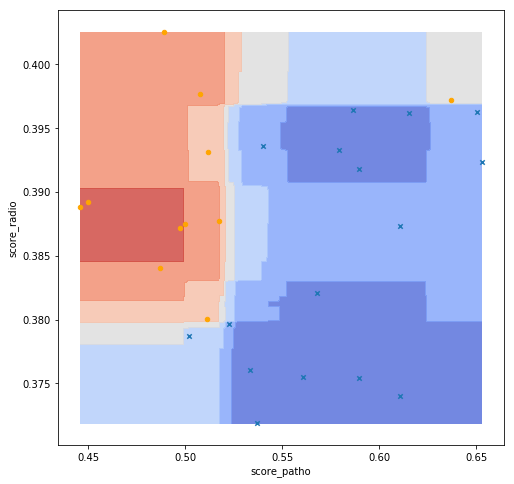

In [828]:
X = df_combined_agg.drop("ytrue", axis=1).values
y = df_combined_agg["ytrue"].values

# r = DecisionTreeClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=2)
r = RandomForestClassifier(n_estimators=150, max_depth=2)
r.fit(X, y)

fig, ax = plt.subplots(figsize=(8, 8))

xx, yy = make_meshgrid(df_combined_agg.score_patho, df_combined_agg.score_radio)

plot_contours(ax, r, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
#              alpha=0.6)

df_combined_agg.query("ytrue==0.").plot.scatter(x="score_patho", y="score_radio", marker="x", ax=ax)
df_combined_agg.query("ytrue==1.").plot.scatter(x="score_patho", y="score_radio", marker="o", ax=ax, c='orange')


In [773]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier

In [782]:
[a.coef_ for a in  r.estimators_]

[array([[-0.36279356, -0.01374436]]), array([[-0.17347896,  0.18962498]])]

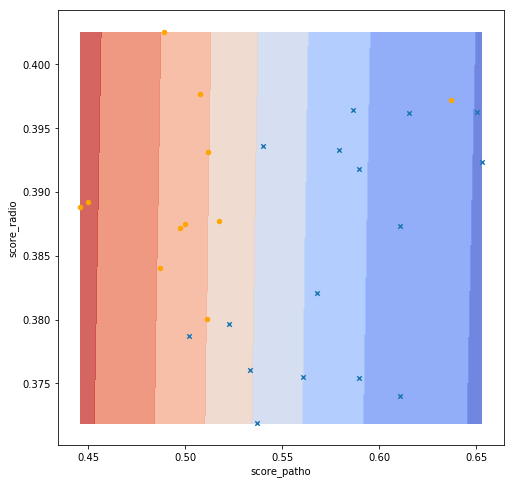

In [793]:
X = df_combined_agg.drop("ytrue", axis=1).values
y = df_combined_agg["ytrue"].values

# r = DecisionTreeClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=2)
# r = BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced'), n_estimators=2)
r = BaggingClassifier(base_estimator=SVC(class_weight='balanced', probability=True, kernel='rbf'), n_estimators=50)
r.fit(X, y)

fig, ax = plt.subplots(figsize=(8, 8))

xx, yy = make_meshgrid(df_combined_agg.score_patho, df_combined_agg.score_radio)

plot_contours(ax, r, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
#              alpha=0.6)

df_combined_agg.query("ytrue==0.").plot.scatter(x="score_patho", y="score_radio", marker="x", ax=ax)
df_combined_agg.query("ytrue==1.").plot.scatter(x="score_patho", y="score_radio", marker="o", ax=ax, c='orange')


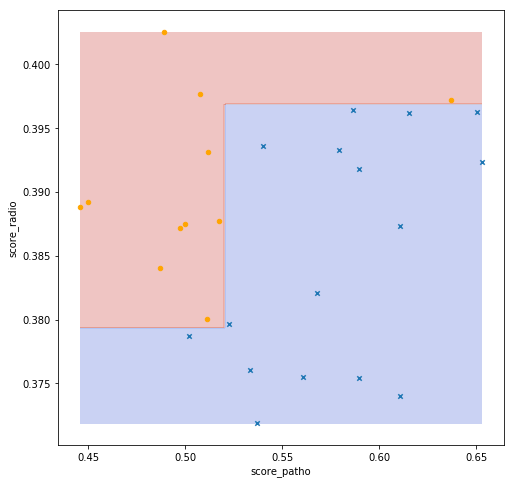

In [766]:
X = df_combined_agg.drop("ytrue", axis=1).values
y = df_combined_agg["ytrue"].values

r = DecisionTreeClassifier(class_weight='balanced', max_depth=2)
# r = RandomForestClassifier()
r.fit(X, y)

fig, ax = plt.subplots(figsize=(8, 8))

xx, yy = make_meshgrid(df_combined_agg.score_patho, df_combined_agg.score_radio)

plot_contours(ax, r, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.3)
#              alpha=0.6)

df_combined_agg.query("ytrue==0.").plot.scatter(x="score_patho", y="score_radio", marker="x", ax=ax)
df_combined_agg.query("ytrue==1.").plot.scatter(x="score_patho", y="score_radio", marker="o", ax=ax, c='orange')


Split for cross-validation

In [554]:
d

,score_patho,score_radio,ytrue
ids,,,
10,0.589736,0.485326,False
11,0.497006,0.485821,True
12,0.610795,0.484990,False
13,0.579012,0.485930,False
14,0.517581,0.486252,True
15,0.511251,0.485270,True
16,0.540236,0.485758,False
17,0.636979,0.486608,True
19,0.511419,0.485355,True


In [740]:
def stats_fit_cv(d):
    y_trues, y_scores = [], []

    kf = KFold(n_splits=4, shuffle=True)
    for _ in range(5):
        for train_index, test_index in kf.split(d.index.get_level_values(0).unique()):
            X_train = d.iloc(axis=0)[train_index, :].drop("ytrue", axis=1).values
            X_test = d.iloc(axis=0)[test_index, :].drop("ytrue", axis=1).values

            y_train = d.iloc(axis=0)[train_index, :]["ytrue"].values
            y_test = d.iloc(axis=0)[test_index, :]["ytrue"].values

            r = DecisionTreeClassifier(class_weight='balanced', max_depth=2)
            # r = RandomForestClassifier(class_weight='balanced')
            r.fit(X_train, y_train)
            y_score = r.predict_proba(X_test)

            y_trues.extend(y_test)
            y_scores.extend(y_score[:, 1])

    print("acc = ", ((np.array(y_scores)>.5) == y_trues).mean())

    fig = plt.figure(figsize=(6, 6))
    fpr, tpr, _ = roc_curve(y_trues, y_scores)
    auc = roc_auc_score(y_trues, y_scores)
    print("auc = ", auc)
    plt.plot(fpr, tpr, lw=2, c='r', alpha=0.8)#, label = r'%s (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.show()

In [797]:
def stats_fit_cv(d):
    y_trues, y_scores = [], []

    kf = KFold(n_splits=4, shuffle=True)
    for _ in range(5):
        for train_index, test_index in kf.split(d.index.get_level_values(0).unique()):
            X_train = d.iloc(axis=0)[train_index, :].drop("ytrue", axis=1).values
            X_test = d.iloc(axis=0)[test_index, :].drop("ytrue", axis=1).values

            y_train = d.iloc(axis=0)[train_index, :]["ytrue"].values
            y_test = d.iloc(axis=0)[test_index, :]["ytrue"].values

            # r = LogisticRegression(class_weight='balanced')
            r = RandomForestClassifier(class_weight='balanced')
            r.fit(X_train, y_train)
            y_score = r.predict_proba(X_test)

            y_trues.extend(y_test)
            y_scores.extend(y_score[:, 1])

    print("acc = ", ((np.array(y_scores)>.5) == y_trues).mean())

    fig = plt.figure(figsize=(8, 8))
    fpr, tpr, _ = roc_curve(y_trues, y_scores)
    auc = roc_auc_score(y_trues, y_scores)
    print("auc = ", auc)
    plt.plot(fpr, tpr, lw=2, c='r', alpha=0.8)#, label = r'%s (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.show()

acc =  0.8518518518518519
auc =  0.9227272727272727


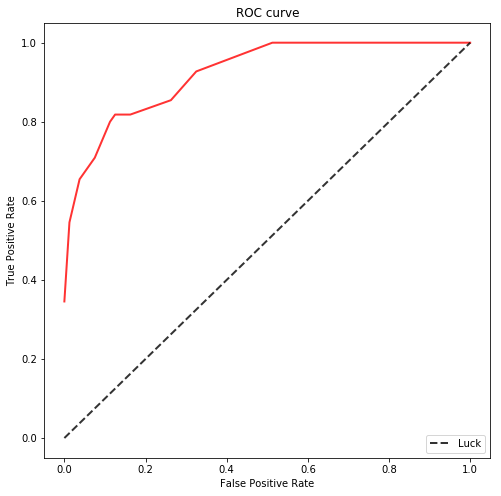

In [697]:
stats_fit_cv(df_combined_agg)

acc =  0.7925925925925926
auc =  0.8340909090909091


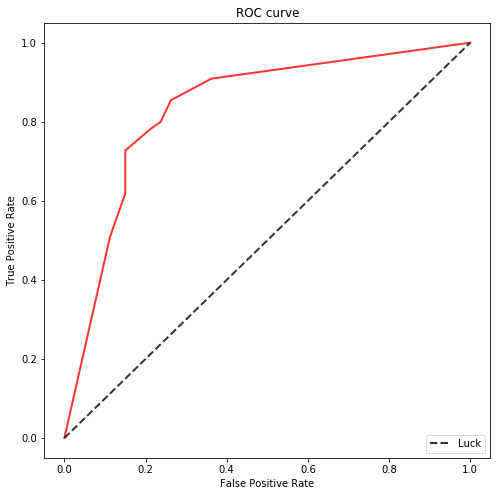

In [709]:
stats_fit_cv(df_combined_agg.loc[:, ["score_patho", "ytrue"]])

acc =  0.7037037037037037
auc =  0.6950000000000001


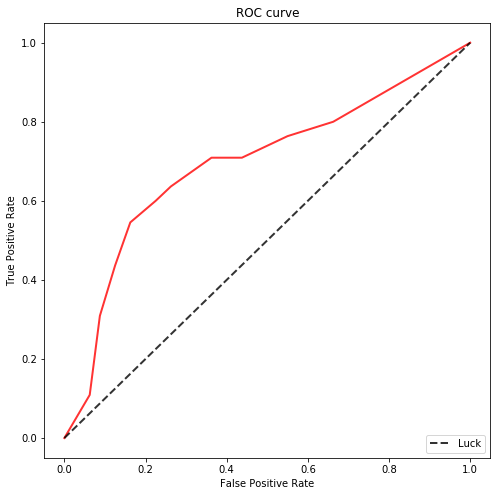

In [687]:
stats_fit_cv(df_combined_agg.loc[:, ["score_radio", "ytrue"]])

Using raw scores

acc =  0.8074074074074075
auc =  0.8438636363636363


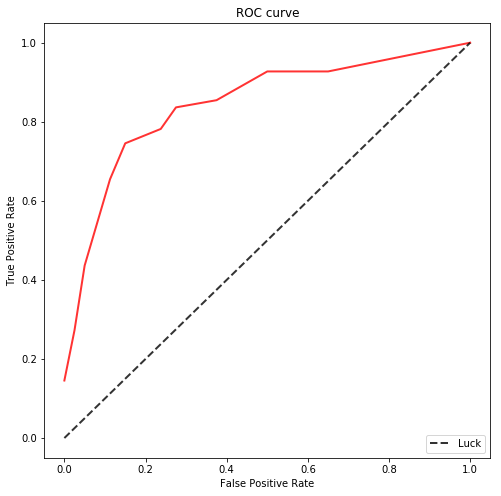

In [799]:
stats_fit_cv(df_combined.query("subids==0"))

acc =  0.7777777777777778
auc =  0.8285227272727274


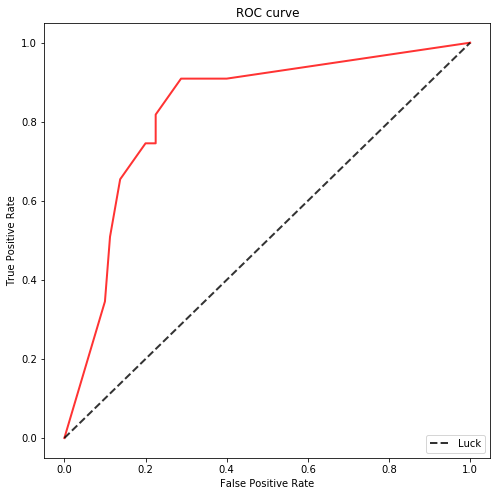

In [801]:
stats_fit_cv(df_combined.query("subids==0").loc[:, ["score_patho", "ytrue"]])

acc =  0.5259259259259259
auc =  0.5436363636363637


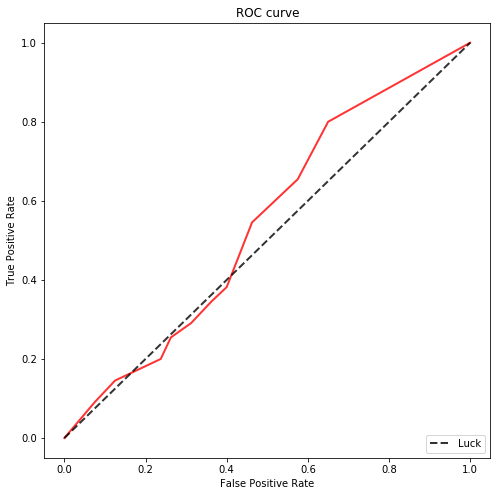

In [803]:
stats_fit_cv(df_combined.query("subids==0").loc[:, ["score_radio", "ytrue"]])

RF on virtual scores

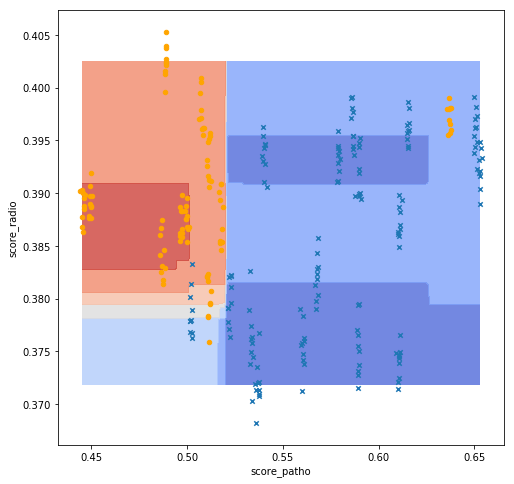

In [824]:
d = df_combined.drop("subids", axis=1)
# d["score_patho"] = d["score_patho"] + np.random.randn(len(d["score_patho"])) * np.var(d["score_patho"])


X = d.drop("ytrue", axis=1).values
y = d["ytrue"].values

# r = DecisionTreeClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=2)
r = RandomForestClassifier(n_estimators=150, max_depth=2)
r.fit(X, y)

fig, ax = plt.subplots(figsize=(8, 8))

xx, yy = make_meshgrid(df_combined_agg.score_patho, df_combined_agg.score_radio)

plot_contours(ax, r, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
#              alpha=0.6)

d.query("ytrue==0.").plot.scatter(x="score_patho", y="score_radio", marker="x", ax=ax)
d.query("ytrue==1.").plot.scatter(x="score_patho", y="score_radio", marker="o", ax=ax, c='orange')
